Autor: Vladimir Indjic, SW 4/2014

# Kalkulator

## 1. Priprema

### Neophodne biblioteke

In [1]:
from __future__ import print_function

%matplotlib inline
import cv2
import numpy as np 
import matplotlib.pyplot as plt 
import collections

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12

Using Theano backend.


### Funkcije za rad sa slikama

In [2]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def image_bin(image_gs):
    height, width = image_gs.shape[0:2]
    image_binary = np.ndarray((height, width), dtype=np.uint8)
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin

def invert(image):
    return 255-image

def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')

def dilate(image):
    kernel = np.ones((3,3))
    return cv2.dilate(image, kernel, iterations=1)

def erode(image):
    kernel = np.ones((3,3))
    return cv2.erode(image, kernel, iterations=1)

### Rad sa regionima

Koristimo parametar cv2.RETR_EXTERNAL kako bismo izdvojili sve spoljne konturu.

In [3]:
def resize_region(region):
    '''Transformisati selektovani region na sliku dimenzija 28x28'''
    return cv2.resize(region,(28,28), interpolation = cv2.INTER_NEAREST)

def select_roi(image_orig, image_bin):
    '''Oznaciti regione od interesa na originalnoj slici. (ROI = regions of interest)
        Za svaki region napraviti posebnu sliku dimenzija 28 x 28. 
        Za označavanje regiona koristiti metodu cv2.boundingRect(contour).
        Kao povratnu vrednost vratiti originalnu sliku na kojoj su obeleženi regioni
        i niz slika koje predstavljaju regione sortirane po rastućoj vrednosti x ose
    '''
    img, contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_regions = [] # lista sortiranih regiona po x osi (sa leva na desno)
    regions_array = []
    for contour in contours: 
        x,y,w,h = cv2.boundingRect(contour) #koordinate i velicina granicnog pravougaonika
        # kopirati [y:y+h+1, x:x+w+1] sa binarne slike i smestiti u novu sliku
        # označiti region pravougaonikom na originalnoj slici (image_orig) sa rectangle funkcijom
        region = image_bin[y:y+h+1,x:x+w+1]
        regions_array.append([resize_region(region), (x,y,w,h)])       
        cv2.rectangle(image_orig,(x,y),(x+w,y+h),(0,255,0),2)
    
    regions_array = sorted(regions_array, key=lambda item: item[1][0])
    sorted_regions = sorted_regions = [region[0] for region in regions_array]
    
    # sortirati sve regione po x osi (sa leva na desno) i smestiti u promenljivu sorted_regions
    return image_orig, sorted_regions

### Priprema za neuronsku mrezu

In [4]:
def scale_to_range(image): # skalira elemente slike na opseg od 0 do 1
    ''' Elementi matrice image su vrednosti 0 ili 255. 
        Potrebno je skalirati sve elemente matrica na opseg od 0 do 1
    '''
    return image/255

def matrix_to_vector(image):
    '''Sliku koja je zapravo matrica 28x28 transformisati u vektor sa 784 elementa'''
    return image.flatten()

def prepare_for_ann(regions):
    '''Regioni su matrice dimenzija 28x28 čiji su elementi vrednosti 0 ili 255.
        Potrebno je skalirati elemente regiona na [0,1] i transformisati ga u vektor od 784 elementa '''
    ready_for_ann = []
    for region in regions:
        # skalirati elemente regiona 
        # region sa skaliranim elementima pretvoriti u vektor
        # vektor dodati u listu spremnih regiona
        scale = scale_to_range(region)
        ready_for_ann.append(matrix_to_vector(scale))
        
    return ready_for_ann

def convert_output(alphabet):
    '''Konvertovati alfabet u niz pogodan za obučavanje NM,
        odnosno niz čiji su svi elementi 0 osim elementa čiji je
        indeks jednak indeksu elementa iz alfabeta za koji formiramo niz.
        Primer prvi element iz alfabeta [1,0,0,0,0,0,0,0,0,0],
        za drugi [0,1,0,0,0,0,0,0,0,0] itd..
    '''
    nn_outputs = []
    for index in range(len(alphabet)):
        output = np.zeros(len(alphabet))
        output[index] = 1
        nn_outputs.append(output)
    return np.array(nn_outputs)

### Kreiranje i obucavanje neuronske mreze

Umesto da predefinisemo broj izlaznih neurona na 10, prosledicemo alfabet za koji pravimo neuronsku mrezu i njegovu velicinu koristiti kao broj izlaznih neurona.

In [5]:
def create_ann(alphabet):
    '''Implementacija veštačke neuronske mreže sa 784 neurona na uloznom sloju,
        128 neurona u skrivenom sloju i 10 neurona na izlazu. Aktivaciona funkcija je sigmoid.
    '''
    ann = Sequential()
    ann.add(Dense(128, input_dim=784, activation='sigmoid'))
    ann.add(Dense(len(alphabet), activation='sigmoid'))
    return ann

def train_ann(ann, X_train, y_train):
    '''Obucavanje vestacke neuronske mreze'''
    X_train = np.array(X_train, np.float32) # dati ulazi
    y_train = np.array(y_train, np.float32) # zeljeni izlazi za date ulaze
   
    # definisanje parametra algoritma za obucavanje
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)

    # obucavanje neuronske mreze
    ann.fit(X_train, y_train, epochs=2000, batch_size=1, verbose = 0, shuffle=False) 
      
    return ann

### Prikaz rezultata

In [6]:
def winner(output): # output je vektor sa izlaza neuronske mreze
    '''pronaći i vratiti indeks neurona koji je najviše pobuđen'''
    return max(enumerate(output), key=lambda x: x[1])[0]

def display_result(outputs, alphabet):
    '''za svaki rezultat pronaći indeks pobedničkog
        regiona koji ujedno predstavlja i indeks u alfabetu.
        Dodati karakter iz alfabet u result'''
    result = []
    for output in outputs:
        result.append(alphabet[winner(output)])
    return result

## 2. Zadatak

### Priprema i treniranje neuronske mreze

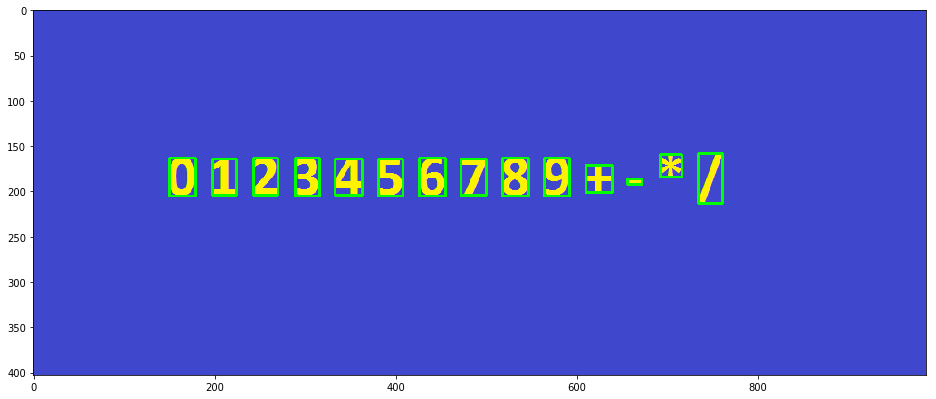

In [7]:
# Ucitavanje i binarizacija slike alfabeta kalkulatora
img_color = load_image('kalkulator_alfabet.png')
img_bin = image_bin(image_gray(img_color))

# Izdvajanje regiona sa karakterima alfabeta
img_selected_regions, characters = select_roi(img_color, img_bin)
display_image(img_selected_regions, True)

# Unosimo alfabet i pripremamo ga za neuronsku mrezu 
alphabet_calc = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-', '*', '/']
outputs = convert_output(alphabet_calc)

# Priprema izdvojenih region sa karakterima
inputs = prepare_for_ann(characters)

# kreiranje neuronske mreze
ann = create_ann(alphabet_calc)
# treniranje neuronske mreze
ann = train_ann(ann, inputs, outputs)



### Testiranje

#### Postupak testiranja

1. Ucitavanje slike
2. Priprema slike
3. Izdvajanje regiona od interesa
4. Priprema za ulaz na neuronsku mrezu
5. Predikcija rezultata
6. Izracunavanje izraza

In [8]:
def predict_result(path, alphabet):
    """
        Proces prepoznavanja i izracunavanja izraza prikazanog na slici.
    """
    # priprema slike
    img_color = load_image(path)
    img_bin = image_bin(image_gray(img_color))
    # izdvajanje regiona
    img_selected_regions, characters = select_roi(img_color, img_bin)
    display_image(img_selected_regions, True)
    # priprema za ulaz u ann
    test_inputs = prepare_for_ann(characters)
    # predikacija
    result = ann.predict(np.array(test_inputs, np.float32))
    result_str = "".join(display_result(result, alphabet))
    print("%s=%d" % (result_str, eval(result_str)))

#### Test 1 (sabiranje.png)

3+2=5


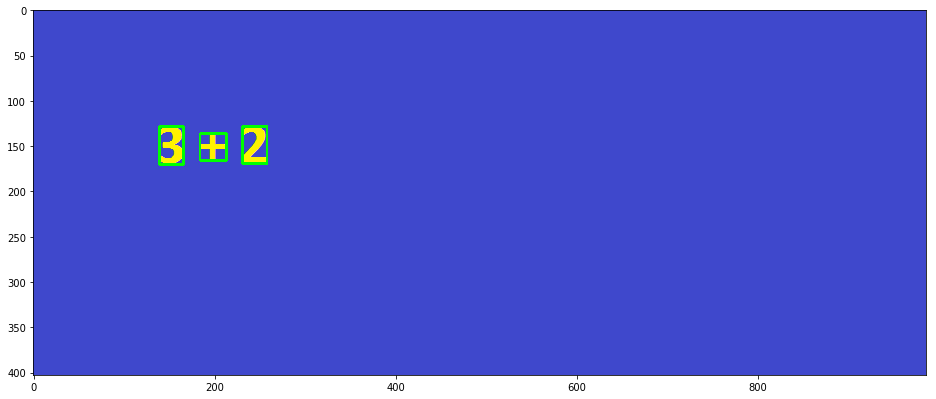

In [9]:
predict_result('sabiranje.png', alphabet_calc)



#### Test 2 (oduzimanje.png)

9-4=5


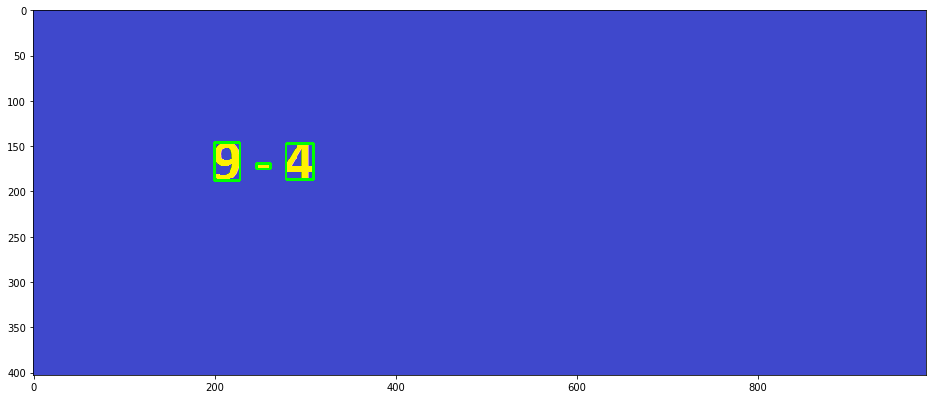

In [10]:
predict_result('oduzimanje.png', alphabet_calc)


#### Test 3 (slozen_izraz.png)

9/3+3*2-1=8


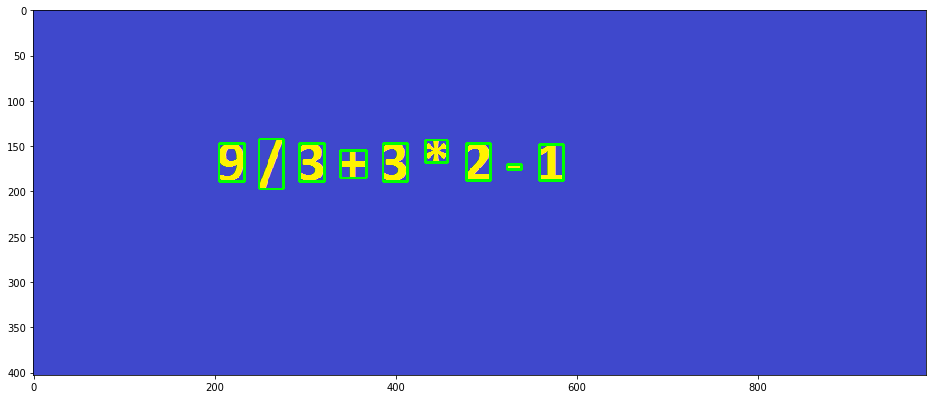

In [11]:
predict_result('slozen_izraz.png', alphabet_calc)